In [808]:
import sys
from PIL import Image  # pip install Pillow
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [809]:
original_file_name = "original.png"
in_file_name = "shuffled.png"
out_file_name = "reconstructed.png"

<h3><center>utils functions</center></h3>

In [681]:
def load_image(file_name):
    img = np.array(Image.open(file_name))
    print("'{}' loaded with shape = {}".format(file_name, img.shape))
    return img

In [682]:
def save_image(img, file_name):
    Image.fromarray(img).save(file_name)

In [683]:
def reconstruct_image(pieces_order, pieces):
    # build columns and them assemble them
    columns = []
    n_cols = pieces_order.shape[1]
    for col in range(n_cols):
        ids_in_col = pieces_order[:, col]
        #print("ids_in_col = {}".format(ids_in_col))
        temp_col = pieces[ids_in_col[0]]
        for idx in ids_in_col[1:]:
            #print(idx)
            temp_col = np.concatenate((temp_col, pieces[idx]), axis=0)
        columns.append(temp_col)
    res = columns[0]
    for i in range(1, len(columns)):
        res = np.concatenate((res, columns[i]), axis=1)
    return res

In [692]:
def shuffle_image(img, n_cols, n_rows):
    # first generate a list of piece indices. Then build the corresponding image
    row_height = int(img.shape[0] / n_rows)
    col_width = int(img.shape[1] / n_cols)
    rows = [img[row_height*i:row_height*(i+1), :, :] for i in range(n_rows)]

    pieces = []
    for row in rows:
        for col_id in range(n_cols):
            pieces.append(row[:, col_width*col_id:col_width*(col_id+1):, :])

    random_order = list(range(n_cols*n_rows))
    shuffle(random_order)  # equivalent to random.shuffle
    random_order = np.array(random_order).reshape(n_rows, n_cols)
    print("random order = {}".format(random_order))
    print("len(pieces) = {}".format(len(pieces)))
    return reconstruct_image(random_order, pieces)

In [693]:
def plot_costs(costs, threshold):
    fig=plt.figure(figsize=(5, 4), dpi= 80, facecolor='w', edgecolor='k')
    #plt.plot(costs)
    plt.axhline(y=threshold)
    plt.scatter(list(range(len(costs))), costs)
    plt.grid()
    plt.savefig("costs.png")

In [694]:
def show_borders_on_image(img, ids, height_ratio=30):
    img_bordered = img.copy()
    height = int(img_bordered.shape[1] * height_ratio / 100)
    for i in ids:
        img_bordered[0:height, i, :] = 0
    save_image(img_bordered, bordered_file_name)

In [695]:
def smallest_common_diviser(l):
    mini = min(l)
    assert mini > 0
    #print("minimum = {}".format(mini))
    for i in range(mini, 0, -1):
        rests = [e%i for e in l]
        if not any(rests):
            return i
        # print(rests)

<h3><center>create or/and load an image</center></h3>

In [804]:
# create a shuffled image
img_original = load_image(original_file_name)
n_cols_wanted = 1
n_rows_wanted = 3
shuffle_img = shuffle_image(img_original, n_cols_wanted, n_rows_wanted)
save_image(shuffle_img, "shuffled.png")
# [[3, 4], [1, 5], [2, 0]]

'original.png' loaded with shape = (536, 1061, 4)
random order = [[0]
 [2]
 [1]]
len(pieces) = 3


In [805]:
# read shuffled image
img_in = load_image(in_file_name)

'shuffled.png' loaded with shape = (534, 1061, 4)


original image


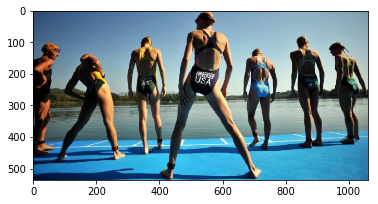

In [806]:
print("original image")
image = plt.imread(original_file_name)
plt.imshow(image)

shuffled image


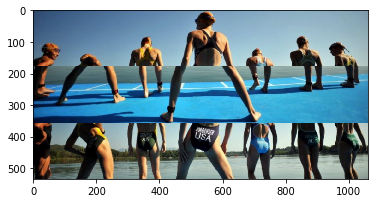

In [807]:
print("shuffled image")
image = plt.imread(in_file_name)
plt.imshow(img_in)

<h3><center>solving functions</center></h3>

In [803]:
def compute_lr_border_cost(s1, s2):
    # compute a fitness score between the right part of s1 and the left part of s2
    r_col = s1[:, -1, :].astype(np.int16)
    l_col = s2[:, 0, :].astype(np.int16)
    diff_col = np.absolute(np.subtract(r_col, l_col))
    return np.sum(diff_col)

In [778]:
def find_n_cols(img, threshold):
    # assuming a constant column width
    costs = []
    ids = []
    print("width = img.shape[1] = {}".format(img.shape[1]))
    for i in range(img.shape[1]-1):
        l = img[:, i:i+1, :]
        r = img[:, i+1:i+2, :]
        cost = compute_lr_border_cost(l, r)
        costs.append(cost)
    for i, c in enumerate(costs):
        if c > threshold:
            ids.append(i)
    print("{} transitions above threshold={} @ pixel {}".format(len(ids), threshold, ids))
    plot_costs(costs, threshold)
    if len(ids) == 0:
        return 1
    if len(ids) == 1:
        col_width = min(img.shape[1] - ids[0], ids[0])
        print(img.shape[1] / col_width)
        res = round(img.shape[1] / col_width)
        return res
    gaps = [ids[i+1]-ids[i] for i in range(len(ids)-1)]   
    print("gaps = {}".format(gaps))
    col_width = smallest_common_diviser(gaps)
    #print("col_width = {}".format(col_width))
    res = int(img.shape[1] / col_width)
    return res

In [779]:
def find_n_rows(img, threshold):
    print(img.shape)
    copy_img = np.copy(img)
    print(copy_img.shape)
    rot_img = np.copy(np.rot90(copy_img))
    print(rot_img.shape)
    print(copy_img.shape)

    return find_n_cols(rot_img, threshold)

In [780]:
def find_first_piece(lr_costs_matrix, ud_costs_matrix):
    # which one to go at the top-left corner
    lr_scores = np.min(lr_costs_matrix, axis=0)
    ud_scores = np.min(ud_costs_matrix, axis=0)
    tot_scores = lr_scores + ud_scores
    print(lr_scores)
    print(ud_scores)
    id_top_right_corner = np.argmax(tot_scores)
    print(id_top_right_corner)
    return id_top_right_corner

In [781]:
class Solver:
    # lr = left-right
    # td = top-down
    def __init__(self, lr_costs_matrix, td_costs_matrix, n_cols, n_rows, first_piece):
        self.lr_cost_matrix = np.copy(lr_costs_matrix)
        self.td_cost_matrix = np.copy(td_costs_matrix)
        self.n_cols = n_cols
        self.n_rows = n_rows
        print("first_piece = {}".format(first_piece))
        self.first_piece = first_piece
        self.used_ids = []
        self.res_in_levels = []
    
    def get_idx(self, level, row):
        # print("asking idx for row = {} and level = {}".format(row, level))
        assert level >= row
        col = level - row
        idx = row * self.n_cols + col
        print("idx = {} for level = {} and row = {}".format(idx, level, row))
        return idx

    def get_idx_parents(self, level, row):
        # parents have level-1
        # parent_l has col-1 and same row
        # parent_t has same col and row-1
        if level == 0:
            return None, None
        parents_level = level - 1
        if row == level:  # child is on left-most column 
            return None, self.get_idx(parents_level, row-1)
        if row == 0:  # child is on top-most column
            return self.get_idx(parents_level, 0), None
        parent_l_row = row
        parent_t_row = row - 1
        parent_l = self.get_idx(parents_level, parent_l_row)
        parent_t = self.get_idx(parents_level, parent_t_row)
        return parent_l, parent_t
    
    def find_best(self, parent_l, parent_t):
        # print("asking best for parent_l = {} and parent_t = {}".format(parent_l, parent_t))
        r_candidates = self.lr_cost_matrix[parent_l, :] if parent_l is not None else 0
        d_candidates = self.td_cost_matrix[parent_t, :] if parent_t is not None else 0
        # print("r_candidates = {}".format(r_candidates))
        # print("d_candidates = {}".format(d_candidates))
        total_candidates = r_candidates + d_candidates
        found = False
        while not found:
            if np.min(total_candidates) == np.inf:
                print("ERROR: no piece found after self.res_in_levels = [{}]".format(self.res_in_levels))
                return None
            best = np.argmin(total_candidates)
            if best in self.used_ids:
                print("ISSUE: want to add {} a second time as child of parent_l = {} and parent_t = {}".format(best, parent_l, parent_t))
                total_candidates[best] = np.inf
            else:
                found = True
                self.used_ids.append(best)
        return best
    
    def format_res_levels(self, res_in_levels):
        res = np.zeros((self.n_rows, self.n_cols))
        for row in range(self.n_rows):
            for col in range(self.n_cols):
                level = row + col
                res[row, col] = res_in_levels[level][row]
        print("res_in_levels = {}".format(res_in_levels))
        print("format_levels = {}".format(res))
        return res.astype(np.int16)

    def get_id_in_res(self, position_in_flat_list, res_in_levels):
        row = position_in_flat_list // self.n_cols
        col = position_in_flat_list % self.n_cols
        level = row + col
        print("for position_in_flat_list = {} and res_in_levels = {}, level = {}, row = {} and col = {}".format(position_in_flat_list, res_in_levels, level, row, col))
        piece_at_position = res_in_levels[level][row]
        print("at this position is {}".format(piece_at_position))
        return piece_at_position
    
    def solve(self):
        self.lr_cost_matrix[:, self.first_piece] = np.inf  # first piece cannot be a right-neighbour
        self.td_cost_matrix[:, self.first_piece] = np.inf  # first piece cannot be a down-neighbour
        self.used_ids.append(self.first_piece)
        self.res_in_levels = [[first_piece]]  # alone in level=0
        
        for level in range(1, self.n_cols + self.n_rows - 1):
            list_for_level = []
            for row_id in range(min(self.n_rows, level+1)):  # no need to explore row > n_rows
                print("  - asking for parents-ids for row = {} and level = {}".format(row_id, level))
                if level + 1 - row_id > self.n_cols:
                    list_for_level.append(None)
                    print("  - excluding row = {} and level = {}".format(row_id, level))
                else:
                    # position of the parents in the 0, 1, 2 ... coordinate system
                    parent_l_out, parent_t_out = self.get_idx_parents(level, row_id)
                    print("answering parent_l_out = {} and parent_t_out = {}".format(parent_l_out, parent_t_out))
                    parent_l_in = self.get_id_in_res(parent_l_out, self.res_in_levels) if parent_l_out is not None else None
                    parent_t_in = self.get_id_in_res(parent_t_out, self.res_in_levels) if parent_t_out is not None else None
                    #parent_l_in = self.used_ids[parent_l_out] if parent_l_out is not None else None
                    #parent_t_in = self.used_ids[parent_t_out] if parent_t_out is not None else None
                    print("i.e. parent_l_in = {} and parent_t_in = {}".format(parent_l_in, parent_t_in))
                    best = self.find_best(parent_l_in, parent_t_in)
                    print("best = {} for parent_l_in = {} and parent_t_in = {}".format(best, parent_l_in, parent_t_in))
                    list_for_level.append(best)
            self.res_in_levels.append(list_for_level)

        #res = self.flatten_levels(self.res_in_levels)
        #res = self.reshape_ids_list(res)
        res = self.format_res_levels(self.res_in_levels)
        return res

In [782]:
# tests
s = Solver(None, None, n_cols=3, n_rows=2, first_piece=0)
s.get_idx(level=1, row=1)
s.get_idx(level=1, row=0)

lr_costs = np.array([[np.inf, 3, 4], [1, np.inf, 0], [2, 5, np.inf]])
print(lr_costs[0][2]) # = cost of having s0 at the left of s2
print(lr_costs)

first_piece = 0
idx = 3 for level = 1 and row = 1
idx = 1 for level = 1 and row = 0
4.0
[[inf  3.  4.]
 [ 1. inf  0.]
 [ 2.  5. inf]]


<h3><center>extract pieces</center></h3>

width = img.shape[1] = 1060
9 transitions above threshold=40000 @ pixel [105, 211, 317, 423, 529, 635, 741, 847, 953]
gaps = [106, 106, 106, 106, 106, 106, 106, 106]
10 = n_cols
106 = col_width


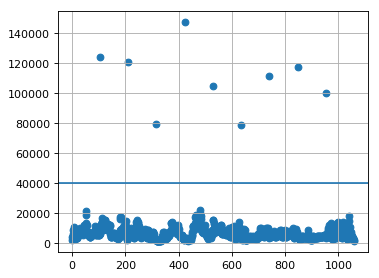

In [783]:
# get number of columns
n_cols = find_n_cols(img_in, threshold=40000)  # play with threshold=... 
col_width = int(img_in.shape[1] / n_cols)
print("{} = n_cols".format(n_cols))
print("{} = col_width".format(col_width))

(531, 1060, 4)
(531, 1060, 4)
(1060, 531, 4)
(531, 1060, 4)
width = img.shape[1] = 531
8 transitions above threshold=120000 @ pixel [58, 117, 176, 235, 294, 353, 412, 471]
gaps = [59, 59, 59, 59, 59, 59, 59]
9 = n_rows
59 = row_height


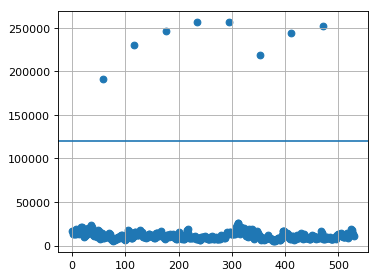

In [785]:
# get number of rows
n_rows = find_n_rows(img_in, threshold=120000)  # play with threshold=... 
row_height = int(img_in.shape[0] / n_rows)
print("{} = n_rows".format(n_rows))
print("{} = row_height".format(row_height))

In [787]:
# create pieces
rows = [img_in[row_height*i:row_height*(i+1), :, :] for i in range(n_rows)]
print(len(rows))
pieces = []
for row in rows:
    for id_col in range(n_cols):
        pieces.append(row[:, col_width*id_col:col_width*(id_col+1), :])
print(len(pieces))
print(pieces[-1].shape)
#plt.imshow(pieces[3])

9
90
(59, 106, 4)


<h3><center>compute best order</center></h3>

In [788]:
# compute fitness score for each neighbouring combination
n_pieces = n_cols*n_rows
lr_border_costs = np.zeros((n_pieces, n_pieces))
td_border_costs = np.zeros((n_pieces, n_pieces))
for p1 in range(n_pieces):
    for p2 in range(n_pieces):
        lr_border_costs[p1][p2] = np.inf if p1==p2 else compute_lr_border_cost(pieces[p1], pieces[p2])
        td_border_costs[p1][p2] = np.inf if p1==p2 else compute_lr_border_cost(np.rot90(pieces[p1]), np.rot90(pieces[p2]))
print(lr_border_costs)
print(td_border_costs)

[[   inf  9627. 16024. ... 17665. 15351. 12865.]
 [12028.    inf 13255. ... 14404. 12882.  8628.]
 [15389. 12425.    inf ... 17943.  4871.  5909.]
 ...
 [17652. 13452. 18679. ...    inf 17862. 14632.]
 [15120. 14342.  8023. ... 20608.    inf 10774.]
 [12785.  9041.  9028. ... 16463.  8041.    inf]]
[[   inf 42095. 28788. ... 21011. 46500. 26034.]
 [15985.    inf 30921. ... 35970. 14471. 29377.]
 [24680. 31353.    inf ... 20527. 27802.   858.]
 ...
 [24439. 32506. 19833. ...    inf 29619. 10727.]
 [32611. 28610. 35795. ... 34526.    inf 22991.]
 [18941. 28460. 23715. ... 19610. 31513.    inf]]


[1.310e+02 2.150e+02 1.361e+03 1.000e+02 3.557e+03 1.311e+03 1.350e+02
 1.060e+02 1.269e+03 4.200e+01 4.210e+02 2.080e+03 1.180e+02 4.430e+02
 2.791e+03 4.970e+02 1.410e+02 2.640e+02 1.590e+02 3.000e+00 2.524e+03
 7.950e+02 7.941e+03 2.180e+02 1.760e+02 9.680e+02 6.270e+02 1.413e+03
 6.660e+02 3.710e+02 9.000e+01 5.830e+02 1.440e+02 3.500e+01 9.070e+02
 3.285e+03 7.000e+00 1.110e+03 3.100e+01 1.690e+02 2.798e+03 2.870e+02
 4.722e+03 3.300e+01 2.750e+03 1.686e+03 1.517e+03 6.500e+01 3.970e+02
 1.404e+03 3.704e+03 3.080e+02 9.840e+02 2.000e+01 2.910e+02 5.900e+01
 3.500e+01 1.784e+03 6.180e+02 1.136e+03 2.420e+02 3.270e+02 3.900e+01
 1.970e+02 3.340e+02 2.610e+02 2.800e+01 3.700e+01 3.780e+02 1.100e+01
 4.990e+02 2.670e+02 1.580e+02 1.060e+02 2.160e+02 1.780e+03 5.500e+01
 3.760e+02 7.700e+01 1.750e+02 1.410e+02 2.111e+03 5.490e+02 1.140e+02
 7.600e+01 1.494e+03 2.378e+03 5.670e+02 2.440e+02 1.820e+02]
[4684. 1449.  981. 2419. 1765. 1773.  656.  176. 3066.  810.  946.  482.
  843. 1166. 

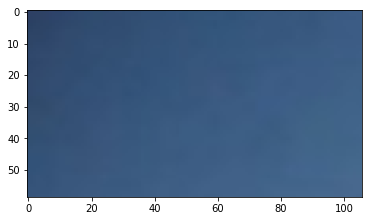

In [810]:
# find first piece (top-left corner)
first_piece = find_first_piece(lr_border_costs, td_border_costs)
print("first_piece = {}".format(first_piece))
print("top-left piece:")
plt.imshow(pieces[first_piece])

In [811]:
# find best order starting from first_piece
solver = Solver(lr_border_costs, td_border_costs, n_cols, n_rows, first_piece)

first_piece = 42


In [812]:
good_order = solver.solve()
print(good_order)

  - asking for parents-ids for row = 0 and level = 1
idx = 0 for level = 0 and row = 0
answering parent_l_out = 0 and parent_t_out = None
for position_in_flat_list = 0 and res_in_levels = [[42]], level = 0, row = 0 and col = 0
at this position is 42
i.e. parent_l_in = 42 and parent_t_in = None
best = 76 for parent_l_in = 42 and parent_t_in = None
  - asking for parents-ids for row = 1 and level = 1
idx = 0 for level = 0 and row = 0
answering parent_l_out = None and parent_t_out = 0
for position_in_flat_list = 0 and res_in_levels = [[42]], level = 0, row = 0 and col = 0
at this position is 42
i.e. parent_l_in = None and parent_t_in = 42
best = 37 for parent_l_in = None and parent_t_in = 42
  - asking for parents-ids for row = 0 and level = 2
idx = 1 for level = 1 and row = 0
answering parent_l_out = 1 and parent_t_out = None
for position_in_flat_list = 1 and res_in_levels = [[42], [76, 37]], level = 1, row = 0 and col = 1
at this position is 76
i.e. parent_l_in = 76 and parent_t_in = No

In [813]:
reconstructed_img = reconstruct_image(good_order, pieces)

In [814]:
save_image(reconstructed_img, out_file_name)

reconstructed image


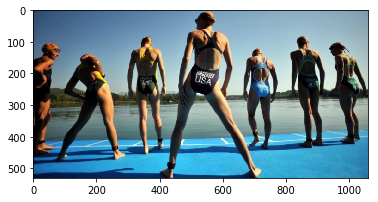

In [815]:
print("reconstructed image")
image = plt.imread(out_file_name)
plt.imshow(image)

<h4><center>draft</center></h4>

In [30]:
# important to define a signed type for subtractions
a = np.arange(9, dtype=np.uint8).reshape(3,3)
b = a+a
print(a-b)

[[  0 255 254]
 [253 252 251]
 [250 249 248]]


In [31]:
a = a.astype(np.int16)
b = b.astype(np.int16)
print(a-b)

[[ 0 -1 -2]
 [-3 -4 -5]
 [-6 -7 -8]]
